```
Create a basic model using only the categorical features.

* There are so many categorical features, how would you deal with so many of them ?
* Plot learning curves to see whether our model is suffering from underfitting or overfitting ?
* Whether we should consider outliers in our calculation or not ? 
```

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os,sys

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.learning_curve import learning_curve

from scipy.stats.mstats import gmean

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

basepath = os.path.expanduser('~/Desktop/src/AllState_Claims_Severity/')
sys.path.append(os.path.join(basepath, 'src'))

np.random.seed(2016)

from data import *

In [2]:
train, test, sample_sub = load_data()

In [3]:
# concat train and test
data = pd.concat((train, test))

In [4]:
# categorical features
categorical_features = [col for col in data.columns if 'cat' in col]

# numerical features
numerical_features = [col for col in data.columns if 'cont' in col]

** Label Encode every categorical feature **

In [5]:
def label_encoding(data, categorical_features):
    for feat in categorical_features:
        lbl = LabelEncoder()
        lbl.fit(data[feat])
        
        data[feat] = lbl.transform(data[feat])
        
    return data

In [6]:
data = label_encoding(data, categorical_features)

In [42]:
train = data[:len(train)]
test  = data[len(train):]

y     = np.log(train.loss)

In [9]:
# remove instances with very high value of loss
mask_non_outlier = train.loss < 6e4

train = train[mask_non_outlier]

In [43]:
X     = train[categorical_features + numerical_features]
Xtest = test[categorical_features + numerical_features]

** Train Test Split **

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, train.loss, test_size=0.33, random_state=12313)

In [45]:
print(X_train.shape, X_test.shape)

(126169, 130) (62143, 130)


** Set up cross-validation scheme **

In [48]:
def cv_xgboost(train, target):
    kf = KFold(len(train), n_folds=3, shuffle=True, random_state=12313)
    scores = []
    
    for i, (itr, ite) in enumerate(kf):
        print('Fold: {}'.format(i))
        
        Xtr = train.iloc[itr]
        Xte = train.iloc[ite]
        
        ytr = target.iloc[itr]
        yte = target.iloc[ite]
        
        # set up configurations
        params = {}

        params['max_depth']        = 8
        params['objective']        = 'reg:linear'
        params['eta']              = 0.03
        params['nthread']          = 4
        params['gamma']            = 2
        params['min_child_weight'] = 7
        params['subsample']        = 0.9
        params['colsample_bytree'] = 0.6
        
        n_rounds = 600
        
        ytr_transformed = np.log(ytr)
        yte_transformed = np.log(yte)
        
        Dtrain = xgb.DMatrix(Xtr, ytr_transformed)
        Dval   = xgb.DMatrix(Xte, yte_transformed)
        plst   = list(params.items())

        
        # define a watch list to observe the change in error for training and holdout data
        watchlist  = [ (Dtrain, 'train'),(Dval, 'eval')]

        model = xgb.train(plst, 
                          Dtrain, 
                          n_rounds,
                          watchlist,
                          feval=mae,  # custom evaluation function
                          early_stopping_rounds=50) # stops 50 iterations after marginal improvements or drop in performance on your hold out set
        
        print('best ite:',model.best_iteration)
        print('best score:',model.best_score)
 
        yhat = model.predict(Dval)
        yhat = np.exp(yhat)
        
        score = mean_absolute_error(np.exp(yte_transformed), yhat)
        print('MAE: {}'.format(score))
        
        scores.append(score)
    
    return scores

** Plot learning curves. **

In [31]:
shallow_depth_est = RandomForestRegressor(n_estimators=10, max_depth=2, n_jobs=-1, random_state=12313)

train_size, train_score, test_score = learning_curve(shallow_depth_est, X_train, y_train, \
                                                     cv=3, scoring='mean_absolute_error', n_jobs=-1)

In [32]:
print('Train sizes: ', train_size)
print('Mean training score ', train_score.mean(axis = 1))
print('Mean test score ', test_score.mean(axis = 1))

Train sizes:  [ 8411 27337 46263 65189 84115]
Mean training score  [-1530.81359495 -1567.75970182 -1576.88311474 -1573.07911587 -1559.10018817]
Mean test score  [-1549.09457279 -1568.04310566 -1580.55965248 -1573.79830461 -1559.84554196]


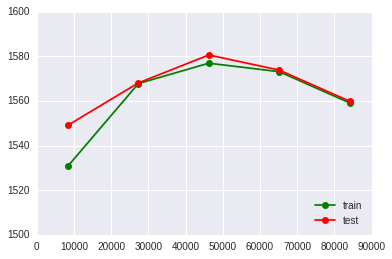

In [36]:
plt.plot(train_size, abs(train_score.mean(axis = 1)), 'g-', marker='o', label='train')
plt.plot(train_size, abs(test_score.mean(axis = 1)), 'r-', marker='o', label='test')
plt.ylim((1500, 1600))
plt.legend(loc='lower right');

In [37]:
normal_est = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=12313)

train_size, train_score, test_score = learning_curve(normal_est, X_train, y_train, \
                                                     cv=3, scoring='mean_absolute_error', n_jobs=-1)

In [38]:
print('Train sizes: ', train_size)
print('Mean training score ', train_score.mean(axis = 1))
print('Mean test score ', test_score.mean(axis = 1))

Train sizes:  [ 8411 27337 46263 65189 84115]
Mean training score  [-1101.42664674 -1226.6468845  -1249.87008574 -1263.66616923 -1269.57408186]
Mean test score  [-1353.51409791 -1341.8992127  -1333.93950953 -1330.74951532 -1328.64392272]


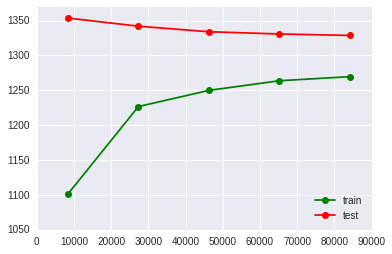

In [41]:
plt.plot(train_size, abs(train_score.mean(axis = 1)), 'g-', marker='o', label='train')
plt.plot(train_size, abs(test_score.mean(axis = 1)), 'r-', marker='o', label='test')
plt.ylim((1050, 1370))
plt.legend(loc='lower right');

** Overfitting **

In [42]:
normal_est = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1, random_state=12313)

train_size, train_score, test_score = learning_curve(normal_est, X_train, y_train, \
                                                     cv=3, scoring='mean_absolute_error', n_jobs=-1)

In [43]:
print('Train sizes: ', train_size)
print('Mean training score ', train_score.mean(axis = 1))
print('Mean test score ', test_score.mean(axis = 1))

Train sizes:  [ 8411 27337 46263 65189 84115]
Mean training score  [-1372.60767003 -1431.11295215 -1436.22183437 -1438.07134662 -1436.53568664]
Mean test score  [-1431.02974653 -1448.39103248 -1448.99175233 -1446.29437829 -1444.55096308]


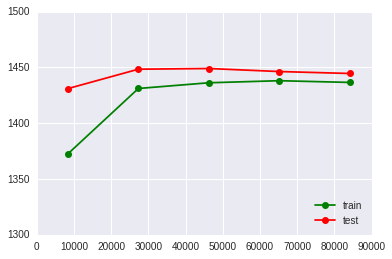

In [46]:
plt.plot(train_size, abs(train_score.mean(axis = 1)), 'g-', marker='o', label='train')
plt.plot(train_size, abs(test_score.mean(axis = 1)), 'r-', marker='o', label='test')
plt.ylim((1300, 1500))
plt.legend(loc='lower right');

** Better. **

** Bring on XGBoost **

In [23]:
def mae(y, y0):
    
    y0=y0.get_label()    
    return 'error',mean_absolute_error(np.exp(y), np.exp(y0))

** Run cross-validation **

In [49]:
scores = cv_xgboost(X_train, y_train)

Fold: 0


Will train until eval error hasn't decreased in 50 rounds.
[0]	train-error:3032.890869	eval-error:3037.093262
[1]	train-error:3032.414551	eval-error:3036.617188
[2]	train-error:3031.847168	eval-error:3036.050049
[3]	train-error:3031.173584	eval-error:3035.376709
[4]	train-error:3030.379639	eval-error:3034.583252
[5]	train-error:3029.449951	eval-error:3033.654297
[6]	train-error:3028.364502	eval-error:3032.569824
[7]	train-error:3027.106934	eval-error:3031.312744
[8]	train-error:3025.655518	eval-error:3029.862793
[9]	train-error:3023.989258	eval-error:3028.197266
[10]	train-error:3022.086670	eval-error:3026.297119
[11]	train-error:3019.923828	eval-error:3024.136963
[12]	train-error:3017.476074	eval-error:3021.691162
[13]	train-error:3014.721436	eval-error:3018.940430
[14]	train-error:3011.629639	eval-error:3015.852539
[15]	train-error:3008.177246	eval-error:3012.406494
[16]	train-error:3004.335449	eval-error:3008.573730
[17]	train-error:3000.077148	eval-error:3004.322510
[18]	train-erro

best ite: 596
best score: 1155.459351
MAE: 1155.4820187721077
Fold: 1


Will train until eval error hasn't decreased in 50 rounds.
[0]	train-error:3026.852051	eval-error:3049.170654
[1]	train-error:3026.376465	eval-error:3048.695068
[2]	train-error:3025.809082	eval-error:3048.127686
[3]	train-error:3025.136230	eval-error:3047.454346
[4]	train-error:3024.342529	eval-error:3046.660889
[5]	train-error:3023.412354	eval-error:3045.729980
[6]	train-error:3022.327881	eval-error:3044.644287
[7]	train-error:3021.071533	eval-error:3043.386963
[8]	train-error:3019.621582	eval-error:3041.936768
[9]	train-error:3017.957031	eval-error:3040.270264
[10]	train-error:3016.055420	eval-error:3038.367188
[11]	train-error:3013.893311	eval-error:3036.202881
[12]	train-error:3011.446533	eval-error:3033.754395
[13]	train-error:3008.691162	eval-error:3030.996338
[14]	train-error:3005.601807	eval-error:3027.904541
[15]	train-error:3002.149414	eval-error:3024.449951
[16]	train-error:2998.306885	eval-error:3020.604492
[17]	train-error:2994.052246	eval-error:3016.346924
[18]	train-erro

best ite: 597
best score: 1147.85376
MAE: 1147.8613418546302
Fold: 2


Will train until eval error hasn't decreased in 50 rounds.
[0]	train-error:3043.131592	eval-error:3016.610352
[1]	train-error:3042.655518	eval-error:3016.134521
[2]	train-error:3042.087402	eval-error:3015.566406
[3]	train-error:3041.413818	eval-error:3014.892822
[4]	train-error:3040.619629	eval-error:3014.098877
[5]	train-error:3039.687988	eval-error:3013.167480
[6]	train-error:3038.602051	eval-error:3012.082031
[7]	train-error:3037.343994	eval-error:3010.824219
[8]	train-error:3035.892090	eval-error:3009.372559
[9]	train-error:3034.224365	eval-error:3007.705322
[10]	train-error:3032.319092	eval-error:3005.801270
[11]	train-error:3030.152588	eval-error:3003.636230
[12]	train-error:3027.700439	eval-error:3001.185547
[13]	train-error:3024.941406	eval-error:2998.427246
[14]	train-error:3021.844238	eval-error:2995.330566
[15]	train-error:3018.383057	eval-error:2991.870117
[16]	train-error:3014.531006	eval-error:2988.019287
[17]	train-error:3010.264648	eval-error:2983.753906
[18]	train-erro

best ite: 597
best score: 1138.137207
MAE: 1138.1470020397087


[598]	train-error:1050.631592	eval-error:1138.143188
[599]	train-error:1050.517212	eval-error:1138.146973


In [34]:
print('Mean score over 3-fold ', np.mean(scores))

Mean score over 3-fold  1155.95444977


In [35]:
params = {}

params['max_depth']        = 8
params['objective']        = 'reg:linear'
params['eta']              = 0.03
params['nthread']          = 4
params['gamma']            = 5
params['min_child_weight'] = 7
params['subsample']        = 0.9
params['colsample_bytree'] = 0.6

n_rounds = 600

plst  = list(params.items())

In [36]:
Dtrain = xgb.DMatrix(X_train, np.log(y_train))
Dval   = xgb.DMatrix(X_test, np.log(y_test))
    
# define a watch list to observe the change in error for training and holdout data
watchlist  = [ (Dtrain, 'train'),(Dval, 'eval')]
 
model = xgb.train(plst, 
                  Dtrain, 
                  n_rounds,
#                   watchlist,
                  feval=mae,  # custom evaluation function
#                   early_stopping_rounds=50
                 )   # stops 50 iterations after marginal improvements or drop in performance on your hold out set

In [37]:
yhat = np.exp(model.predict(Dval))
print('MAE on unseen set ', mean_absolute_error(y_test, yhat))

MAE on unseen set  1148.67915893


** Full Training **

In [38]:
DTRAIN = xgb.DMatrix(X, np.log(train[mask_non_outlier].loss))
DTEST  = xgb.DMatrix(Xtest)

In [39]:
# train on full dataset

model = xgb.train(plst, 
                  DTRAIN, 
                  n_rounds,
                  feval=mae  # custom evaluation function
                 )   # stops 50 iterations after marginal improvements or drop in performance on your hold out set

In [40]:
predictions = model.predict(DTEST)
predictions = np.exp(predictions)

** Public Leaderboard 1129.27001**

In [41]:
sample_sub['loss'] = predictions
sample_sub.to_csv(os.path.join(basepath, 'submissions/xgboost_tuned_even_deeper.csv'), index=False)